###  Sparse GP Regression with FITC and predictive distribution- FITC prior for sampling over f.


This notebook uses the FITC prior to sample over the latent function values. The integration over inducing 
outputs(u) can be done analytically, and we can directly sample from the multivariate Gaussian. Data to be used will be Snelson 1D dataset.

In [12]:
%matplotlib inline
%precision 4
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [5]:
import numpy as np

In [6]:
import scipy.io as sio

In [7]:
df = sio.loadmat('snelson1d.mat')

In [16]:
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [17]:
SEED = 27042018

In [18]:
np.random.seed(seed=SEED)

In [19]:
print("X minimum value:%.3f"%X.min())
print("X maximum value:%.3f"% X.max())

X minimum value:0.059
X maximum value:5.966


In [20]:
M = 20
X_u_noisy = np.linspace(0,6, M)[:, None]
# X_u_noisy = X_u + 0.1*np.random.rand(*X_u.shape) 

In [21]:
N_star = 30
X_star = np.linspace(-1.0, 7.0, N_star)[:, None]

### Code

In [22]:
stan_code_fitc_pred= """
functions{
    vector gp_pred_rng(real[] x_train, vector y, real[] xu, real[] x_star, real alpha, real rho, real sigma, real jitter){
        
        int N1 = rows(y);
        int N2 = size(x_star);
        int M = size(xu);
        matrix[N2, N2] cov_star;
        vector[M] K_div_y;
        vector[N2] f_star_mean;
        
        vector[N2] f_star;
        {
            vector[M] y_scaled;
            vector[M] L_S_div_y;
            matrix[N1,N1] diff;
            matrix[N1,N1] A;
            matrix[M, N1] v_pred;
            matrix[N1, M] S1;
            matrix[M, M] S;
            matrix[M, M] T;
            matrix[M, M] L_S;
            matrix[M, N2] v_pred_star;
            
            matrix[N1, N1] Kff = cov_exp_quad(x_train, alpha, rho);
            matrix[N1, M] Kfu = cov_exp_quad(x_train, xu, alpha, rho);
            matrix[N2, N2] K_star_star = cov_exp_quad(x_star, alpha, rho);
            matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
            
            // matrix[N1, N1] L_K= cholesky_decompose(Kff);
            matrix[M, M] L_U = cholesky_decompose(Kuu);
            matrix[N2, N1] K_star_f = cov_exp_quad(x_star, x_train, alpha, rho);
            matrix[N2, M] K_star_u = cov_exp_quad(x_star, xu, alpha, rho);
            matrix[M, N2]v_star = mdivide_left_tri_low(L_U, K_star_u');

            matrix[N2, N2] Q_star_star = v_star'*v_star;

            A= diag_matrix(rep_vector(0., N1));

            v_pred = mdivide_left_tri_low(L_U, Kfu');
            diff = Kff - v_pred'*v_pred;
            for (i in 1:N1){
                A[i,i] = 1./(diff[i,i]+square(sigma));
            }
            
            S1 = A*Kfu;
            S  = Kfu'*S1;
            
            T  = Kuu + S;
            L_S = cholesky_decompose(T);
            
            // matrix[M,M] S_inv = inverse(S);
            
            v_pred_star = mdivide_left_tri_low(L_S, K_star_u');
            cov_star = K_star_star - Q_star_star + v_pred_star'*v_pred_star;
            y_scaled = Kfu'*(A*y);

            L_S_div_y = mdivide_left_tri_low(L_S, y_scaled);    #forward substitution
            K_div_y = mdivide_right_tri_low(L_S_div_y', L_S)';   #backward substitiion
            f_star_mean = K_star_u*K_div_y;

            f_star = multi_normal_rng(f_star_mean, cov_star);

        }
        return f_star;

    }

}

data {
    int<lower=1> N;
    int<lower=1> M;
    int<lower=1> N_star;
    real x[N];
    real x_star[N_star];
    vector[N] y;
    real xu[M];
}

transformed data {
    real jitter = 1e-8;
#     real rho = 1;
#     real alpha = 1;

}
parameters {
    
    real<lower=1e-6> sigma;
    real <lower=1e-4> alpha;
    real<lower=1e-4> rho;
    vector[M] eta;
}

model {

    vector[N] f_mean;
    matrix[N, N] f_cov;
    matrix[N, N] A;
    matrix[N, N] diff;
        
    {
        matrix[M, M] L_U;
        matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
        matrix[N, M] Kfu = cov_exp_quad(x, xu, alpha, rho);
        matrix[N, N] K = cov_exp_quad(x, alpha, rho);
        vector[M] Kuu_inv_u;
        matrix[M, N] v_pred;
        vector[M] u;
        matrix[N,N] Qff;
        
        for (m in 1:M)
            Kuu[m, m] = Kuu[m, m] + jitter;
                    
        L_U = cholesky_decompose(Kuu);
        u = L_U * eta;
        
        // f_mean = Kfu*(Kuu_inv*u) = Kfu * inv(LL')u = Kfu * inv(L') *inv(L) * L * eta = = Kfu * inv(L') * eta;        
        Kuu_inv_u =  mdivide_left_tri_low(L_U, eta);
        f_mean = Kfu*Kuu_inv_u;
        

        // f_cov = K - Kfu*(Kuu_inv*Kfu');            
        v_pred = mdivide_left_tri_low(L_U, Kfu');
        Qff = v_pred'*v_pred;
        diff = K - Qff;
        for (i in 1:N){
            for(j in 1:N){
                A[i,j] = 0.0;
            }
            A[i,i] = diff[i,i] + square(sigma);
        }
        
        f_cov = A+Qff;
    }
    
    rho ~ normal(0.90, 0.50);
    alpha ~ normal(0.85, 0.50);

    sigma ~ normal(0, 0.60);
    eta ~ normal(0, 1);
    y ~ multi_normal(f_mean, f_cov);
}

generated quantities{
    vector[N_star] f_star = gp_pred_rng(x, y, xu, x_star, alpha, rho, sigma, jitter); 
    // vector[N_star] y_star = normal_rng(f_star, sigma);
    vector[N_star] y_star;
    for (i in 1:N_star){
        y_star[i] = normal_rng(f_star[i], sigma);
    }
    
}


"""


In [23]:
stan_model_fitc = pystan.StanModel(model_code=stan_code_fitc_pred)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_127bf544dea8e38704506785eebd3b99 NOW.


In [24]:
gp_fitc_pred_data = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':M, 'xu':X_u_noisy.flatten(), 'N_star':N_star, 'x_star':X_star.flatten()}

In [25]:
SAMPLES_SIZE = 1400

In [26]:
fit_fitc = stan_model_fitc.sampling(data=gp_fitc_pred_data, iter=SAMPLES_SIZE, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [27]:
print(fit_fitc)

Inference for Stan model: anon_model_127bf544dea8e38704506785eebd3b99.
2 chains, each with iter=1400; warmup=700; thin=1; 
post-warmup draws per chain=700, total post-warmup draws=1400.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma        0.27    0.02   0.02   0.24   0.25   0.25   0.29   0.31      1   2.71
alpha         0.7    0.18   0.18   0.41   0.51   0.87   0.88   0.88      1   3.17
rho          0.57    0.09   0.09   0.41   0.49    0.6   0.65   0.65      1   3.45
eta[0]       -0.1    0.06    0.6  -1.61  -0.22  -0.19 9.7e-3   1.25     98   1.02
eta[1]       0.53    0.52   0.74  -1.39    0.3   0.92   0.96    1.3      2   1.28
eta[2]       0.31    0.26   0.57   -1.1   0.13   0.52   0.54   1.29      5   1.11
eta[3]      -1.56    1.12   1.12  -2.57  -2.56  -2.44  -0.59   0.87      1   2.23
eta[4]      -0.25    0.37   0.63  -1.82  -0.59 2.2e-3   0.08   0.77      3   1.18
eta[5]      -0.07    0.84   0.84  -1.96  -0.65    0.5   0.53   0.72      1 

In [28]:
samples = fit_fitc.extract(permuted=True)


In [32]:
sigma_samples = samples['sigma']
alpha_samples = samples['alpha']
rho_samples = samples['rho']
eta_samples = samples['eta']
f_star_samples = samples['f_star']
y_star_samples = samples['y_star']
eta_mean = np.mean(eta_samples, axis=0)
sigma_mean = np.mean(sigma_samples, axis=0)
alpha_mean = np.mean(alpha_samples, axis=0)
f_star_mean = np.mean(f_star_samples, axis=0)
y_star_mean = np.mean(y_star_samples, axis=0)

##### Plotting sample chain for eta(v).

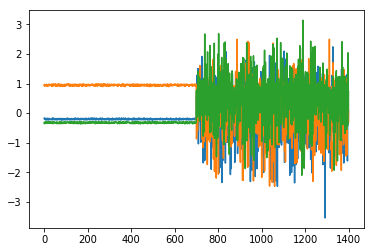

In [29]:
plt.plot(eta[:, 0])
plt.plot(eta[:, 1])
plt.plot(eta[:, 10])

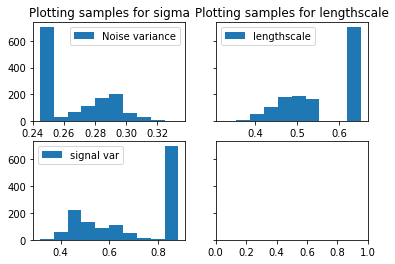

In [33]:
f, axs = plt.subplots(2,2, sharey=True)
axs[0,0].hist(sigma_samples)
axs[0,0].set_title('Plotting samples for sigma')
axs[0,0].legend(['Noise variance'])
axs[0,1].hist(rho_samples)
axs[0,1].set_title('Plotting samples for lengthscale')
axs[0,1].legend(['lengthscale'])
axs[1,0].hist(alpha_samples)
# axs[1,0].set_title('Plotting samples for signalvariance')
axs[1,0].legend(['signal var'])

In [34]:
sigma_mean = np.mean(samples['sigma'])
sigma_median = np.nanmedian(samples['sigma'])

l_mean = np.mean(samples['rho'])
l_median = np.nanmedian(samples['rho'])

sigvar_mean = np.mean(samples['alpha'])
sigvar_median = np.nanmedian(samples['alpha'])

print("mean of noise variance: %.2f" % sigma_mean)
print("median of noise variance: %.2f"% sigma_median)
print("mean of lengthscale: %.3f"% l_mean)
print("median of lengthscale: %.3f"% l_median)
print("mean of signal variance: %.3f"% sigvar_mean)
print("median of signal variance: %.3f"% sigvar_median)


mean of noise variance: 0.27
median of noise variance: 0.25
mean of lengthscale: 0.566
median of lengthscale: 0.595
mean of signal variance: 0.704
median of signal variance: 0.866


#### Plots of two samples drawn for f_star from the predictive distribution for 30 new test points(X*).

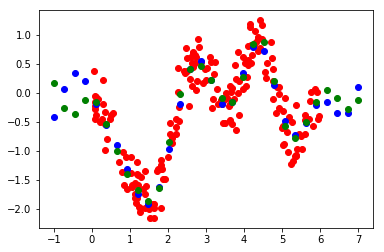

In [35]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, f_star[4,:], 'bo')
plt.plot(X_star, f_star[720,:], 'go')

#### Plots of two randomly drawn samples for y_star for 30 new test points(X*).

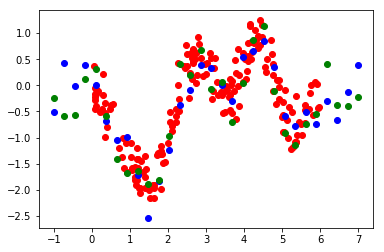

In [37]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, y_star[4,:], 'bo')
plt.plot(X_star, y_star[720,:], 'go')

In [ ]:
plt.plot(X,Y, 'ro')
plt.plot(X, f_perc_25, 'bo')
plt.plot(X, f_perc_975, 'go')

In [39]:
f_star_perc_25 = np.percentile(f_star, 2.5, axis=0)
f_star_perc_975 = np.percentile(f_star, 97.5, axis=0)

In [40]:
y_star_perc_25 = np.percentile(y_star, 2.5, axis=0)
y_star_perc_975 = np.percentile(y_star, 97.5, axis=0)

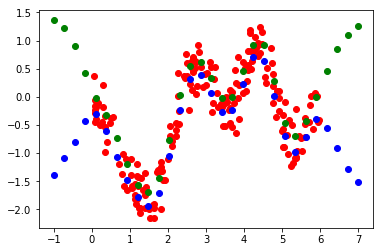

In [43]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, f_star_perc_25, 'bo')
plt.plot(X_star, f_star_perc_975, 'go')

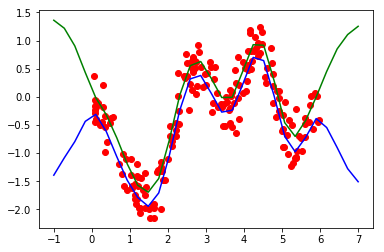

In [80]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, f_star_perc_25, 'b-')
plt.plot(X_star, f_star_perc_975, 'g-')

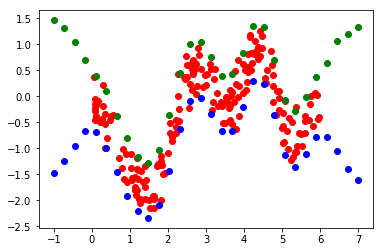

In [42]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, y_star_perc_25, 'bo')
plt.plot(X_star, y_star_perc_975, 'go')

In [82]:
print("Mean difference for fstar between 2.5 and 97.5 percentile: %.3f"%np.mean(f_star_perc_975[5:25] - f_star_perc_25[5:25]))
print("Mean difference for ystar between 2.5 and 97.5 percentile: %.3f"% np.mean(y_star_perc_975 - y_star_perc_25))

Mean difference for fstar between 2.5 and 97.5 percentile: 0.262
Mean difference for ystar between 2.5 and 97.5 percentile: 1.390


In [ ]:
rand_inds = np.random.randint(SAMPLES_SIZE, size=5)

In [49]:
def kernel_rbf(alpha, rho, Xi, Xj=None):
    if Xj is None:
        Xj = Xi
    
    N1,D1 = Xi.shape[0],1
    N2,D2 = Xj.shape[0],1
    
    diff = Xi.reshape(N1,1,D1) - Xj.reshape(1,N2,D2)
    K = (alpha**2)*np.exp(-0.5*np.sum(np.square(diff),-1)/(rho)**2)
    return K

In [68]:

# function to generate mean and covariance matrics ..
def generate_u(alpha, rho, v, Xi):
    Kuu = kernel_rbf(alpha, rho, Xi=Xi)
    R = np.linalg.cholesky(Kuu)

    u_mean = np.dot(R, v)

    return u_mean

In [69]:
N_samples = 1400
N = 200

In [76]:
u_sum = np.zeros(M)
# S_sum = np.zeros((N,N))
for i in range(N_samples):
    u_mean = generate_u(alpha=alpha_samples[i], rho =rho_samples[i], v =eta_samples[i,:], Xi = X_u_noisy)
    u_sum = u_sum + u_mean

In [77]:
u_fin = u_sum / N_samples


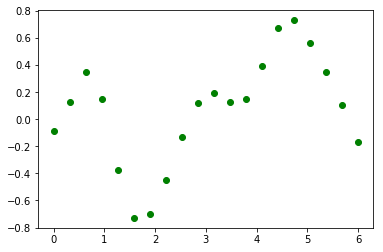

In [78]:
plt.plot(X_u_noisy, u_fin, 'go')

In [60]:
a = np.random.multivariate_normal(f_fin, S_sum, 6)

In [61]:
print(a.shape)

(6, 200)
